# Assignment 4 - Markov Decision Processes

In [1]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import itertools 
import random
import networkx as nx
import plotly.graph_objects as go

In [2]:
evaluation_data = []
random.seed(37)

## Frozen lake problem

In [3]:
# testing
env = gym.make('FrozenLake8x8-v0', is_slippery=True)
observation = env.reset()
env.env.s = 62 # go to state s
s_next, r, done, info = env.step(3)
env.render()
env.close()
print("Next state: {} Reward: {} Done: {} Info: {}".format(s_next, r, done, info))

(Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Next state: 61 Reward: 0.0 Done: False Info: {'prob': 0.3333333333333333}


### Value Iteration

In [4]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def value_iteration(env, max_iterations=100000, lmbda=0.9, verbose=1):
    stateValue = [0 for i in range(env.nS)]
    newStateValue = stateValue.copy()
    iterations = 0
    start_time = time.time()
    for i in range(max_iterations):
        
        if verbose>0: print("Iteration: {}".format(i))
        
        for state in range(env.nS):
            action_values = []      
            
            for action in range(env.nA):
                state_value = 0
                
                for s in range(len(env.P[state][action])):
                    prob, next_state, reward, done = env.P[state][action][s]
                    
                    if verbose>1: 
                        print("Iteration: {} State: {} Action: {} Prob: {} Next State: {} Reward: {}".format(i, state, action, prob, next_state, reward))
                    state_action_value = prob * (reward + lmbda*stateValue[next_state])
                    state_value += state_action_value
                
                action_values.append(state_value)
                best_action = np.argmax(np.asarray(action_values))
                newStateValue[state] = action_values[best_action]
        
        # if i > 1000: 
        if verbose>0: print("Delta V: {}".format(np.max(np.abs(np.array(stateValue) - np.array(newStateValue)))))
        if np.max(np.abs(np.array(stateValue) - np.array(newStateValue))) < 0.0001:
            break
            
        stateValue = newStateValue.copy()
        iterations += 1
    
    duration = time.time() - start_time

    return stateValue, iterations, duration 

In [5]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            # print(env.P[state][action])
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                # print("I: {} R: {}".format(i, r))
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
        # print("State: {} Action Values: {} Best Action: {}".format(state, action_values, best_action))
    return policy 

In [6]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_score(env, policy, episodes=1000):
  misses = 0
  steps_list = []
  for episode in range(episodes):
    observation = env.reset()
    steps=0
    while True:
      
      action = policy[observation]
      observation, reward, done, _ = env.step(action)
      steps+=1
      if done and reward == 1:
        # print('You have got the Frisbee after {} steps'.format(steps))
        steps_list.append(steps)
        break
      elif done and reward == 0:
        # print("You fell in a hole!")
        misses += 1
        break
  print('----------------------------------------------')
  print('You took an average of {:.0f} steps to get the frisbee'.format(np.mean(steps_list)))
  print('And you fell in the hole {:.2f} % of the times'.format((misses/episodes) * 100))
  print('----------------------------------------------')


In [7]:
stateValues, iterations, duration = value_iteration(env, max_iterations=100000, verbose=0)
policy_value_iteration = get_policy(env, stateValues)
get_score(env, policy_value_iteration,episodes=1000)

----------------------------------------------
You took an average of 73 steps to get the frisbee
And you fell in the hole 25.80 % of the times
----------------------------------------------


In [8]:
evaluation_data=[]
evaluation_data.append(('Frozen Lake', 'Value Iteration', sum(stateValues), iterations, duration))

In [9]:
evaluation_data

[('Frozen Lake',
  'Value Iteration',
  3.5886959888016294,
  45,
  0.13098716735839844)]

In [10]:
def display_state_values(V, env, title):
    nb_states = env.observation_space.n
    V = np.round(V, decimals=4)
    ax = sns.heatmap(V.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 linewidth=0.5,
                 annot=V.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 fmt = '',
                 cbar=False).set_title(title)
    plt.show()

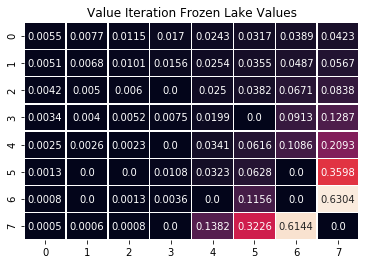

In [11]:
display_state_values(stateValues, env, 'Value Iteration Frozen Lake Values')
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

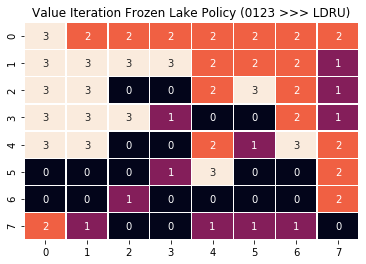

In [12]:
display_state_values(policy_value_iteration, env, 'Value Iteration Frozen Lake Policy (0123 >>> LDRU)')
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

### Policy Iteration

In [13]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_vpi(pi, env, gamma):
    # use pi[state] to access the action that's prescribed by this policy
    
    a = np.identity(env.nS) 
    b = np.zeros(env.nS) 
    
    # print(a)
    # print(b)

    for state in range(env.nS):
        for probability, nextstate, reward, done in env.P[state][pi[state]]:
            a[state][nextstate] = a[state][nextstate] - gamma * probability
            b[state] += probability * reward

    # print(a)
    # print(b)
    
    V = np.linalg.solve(a, b)
    return V

In [14]:
pi = np.arange(64) % env.nA
Vpi = compute_vpi(pi, env, 0.9)

In [15]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_qpi(vpi, env, gamma):
    Qpi = np.zeros([env.nS, env.nA])
    for state in range(env.nS):
        for action in range(env.nA):
            for probability, nextstate, reward, done in env.P[state][action]:
                Qpi[state][action] += probability * (reward + gamma * vpi[nextstate]) 
    return Qpi

In [16]:
Qpi = compute_qpi(Vpi, env, 0.9)

In [17]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def policy_iteration(env, gamma, nIt):
    Vs = []
    pis = []
    pi_prev = np.zeros(env.nS, dtype='int')
    pis.append(pi_prev)
    print("Iteration | # chg actions | V[0]")
    print("----------+---------------+---------")

    start_time = time.time()

    for it in range(nIt):        
        
        # you need to compute qpi which is the state-action values for current pi
        vpi = compute_vpi(pis[-1], env, gamma=gamma)
        qpi = compute_qpi(vpi, env, gamma=gamma)
        pi = qpi.argmax(axis=1)
        print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        pi_prev = pi

        if it > 1 and np.max(np.abs(np.array(Vs[-1]) - np.array(Vs[-2]))) < 0.0001:
            break

    duration = time.time() - start_time
    
    return Vs, pis, it, duration

In [18]:
Vs_PI, pis_PI, iterations, duration = policy_iteration(env, gamma=0.9, nIt=20)

Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |     29        | 0.00000
   1      |     30        | 0.00000
   2      |     18        | 0.00001
   3      |      8        | 0.00539
   4      |      8        | 0.00631
   5      |      1        | 0.00641
   6      |      0        | 0.00641


In [19]:
evaluation_data.append(('Frozen Lake', 'Policy Iteration', sum(Vs_PI[-1]), iterations, duration))

In [20]:
evaluation_data

[('Frozen Lake',
  'Value Iteration',
  3.5886959888016294,
  45,
  0.13098716735839844),
 ('Frozen Lake',
  'Policy Iteration',
  3.61596731425977,
  6,
  0.018025875091552734)]

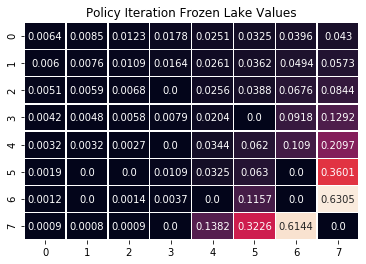

In [21]:
display_state_values(Vs_PI[-1], env, 'Policy Iteration Frozen Lake Values')
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

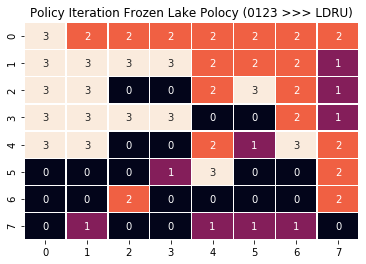

In [22]:
display_state_values(pis_PI[-1], env, 'Policy Iteration Frozen Lake Polocy (0123 >>> LDRU)')
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

In [23]:
get_score(env, pis_PI[-1], episodes=1000)

----------------------------------------------
You took an average of 73 steps to get the frisbee
And you fell in the hole 25.00 % of the times
----------------------------------------------


In [24]:
# is the policy from value and policy iteration the same?
np.array_equal(pis_PI[-1], policy_value_iteration)

False

### Q-Learning

In [25]:
action_size = env.action_space.n
state_size = env.observation_space.n

In [26]:
qtable = np.zeros((state_size, action_size))
qtable.shape

(64, 4)

In [27]:
total_episodes = 30000        # Total episodes
learning_rate = 0.9           # Learning rate
max_steps = 200                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.1            # Minimum exploration probability 
decay_rate = 0.01            # Exponential decay rate for exploration prob

In [28]:
# the following function was inspired by and adapted from: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb

LR = [0.005]

for lr in LR:

    qtable = np.zeros((state_size, action_size))

    total_episodes = 30000        # Total episodes
    learning_rate = 0.9           # Learning rate
    max_steps = 200                # Max steps per episode
    gamma = 0.95                  # Discounting rate

    # Exploration parameters
    epsilon = 1.0                 # Exploration rate
    max_epsilon = 1.0             # Exploration probability at start
    min_epsilon = 0.1            # Minimum exploration probability 
    decay_rate = 0.01            # Exponential decay rate for exploration prob

    decay_rate = lr

    # List of rewards
    rewards = []
    reward_achieved = 0
    start_time = time.time()
    iterations = 0

    # 2 For life or until learning is stopped
    while True:
        # Reset the environment
        state = env.reset()
        old_state = 0
        step = 0
        done = False
        total_rewards = 0
        old_qtable = qtable.copy()
        
        for step in range(max_steps):
            # 3. Choose an action a in the current world state (s)
            ## First we randomize a number
            exp_exp_tradeoff = random.uniform(0, 1)
            
            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state,:])
                # print("Exploiting knowledge!")

            # Else doing a random choice --> exploration
            else:
                action = env.action_space.sample()
                # print("Randomly exploring!")

            # print("Action: {}".format(action))

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)
            # print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))

            # if done and reward == 0:
            #     reward = -0.5

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
            
            total_rewards += reward
            
            # Our new state is state
            old_state = state
            state = new_state
            
            # If done (if we're dead) : finish episode
            if done == True:
                # print("Done") 
                if reward > 0:
                    reward_achieved += 1
                    # print(old_state, action)
                    # print(qtable[old_state, action])
                    # print(learning_rate * (reward + gamma * np.max(qtable[state, :]) - qtable[old_state, action]))
                    # Reduce epsilon (because we need less and less exploration)
                    # print(reward_achieved)
                    # print(decay_rate)
                    # print(np.exp(-decay_rate*reward_achieved))
                    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*reward_achieved)
                    # print("Epsilon: {}".format(epsilon)) 
                    # print("Iterations: {} Action: {} New State: {} R: {} Epsilon: {}".format(iterations, action, new_state, reward, epsilon))
                break
            
        rewards.append(total_rewards)
        iterations += 1
        if abs(epsilon - min_epsilon) < 0.01:
            break

        # print(np.max(np.abs(np.array(old_qtable) - np.array(qtable))))
        # if sum(rewards)>10 and np.max(np.abs(np.array(old_qtable) - np.array(qtable))) < 0.001:
        #     break

    duration = time.time() - start_time
    print ("Number of rewards: " +  str(sum(rewards)))
    print ("Score over time: " +  str(sum(rewards)/total_episodes))
    # print(qtable)

    policy = np.argmax(qtable, axis=1)
    get_score(env, policy,episodes=1000)

    evaluation_data.append(('Frozen Lake', 'Q-learning', np.sum(qtable) / action_size, iterations, duration))

Number of rewards: 900.0
Score over time: 0.03
----------------------------------------------
You took an average of 100 steps to get the frisbee
And you fell in the hole 26.30 % of the times
----------------------------------------------


In [29]:
# policy = [np.argmax(i) for i in qtable]
policy = np.argmax(qtable, axis=1)

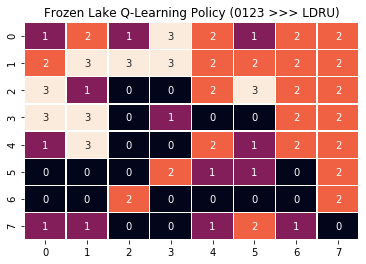

In [30]:
display_state_values(policy, env, 'Frozen Lake Q-Learning Policy (0123 >>> LDRU)')
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

In [31]:
get_score(env, policy,episodes=1000)

----------------------------------------------
You took an average of 96 steps to get the frisbee
And you fell in the hole 26.70 % of the times
----------------------------------------------


## Random MDP

In [32]:
n_states = 100
n_actions = 4
n_rewards = 1

# select which state actions gets a reward
n_state_actions = n_actions * n_states
selected_state_actions = np.arange(n_state_actions)
random.shuffle(selected_state_actions)
selected_state_actions=selected_state_actions[:n_rewards]


In [33]:
selected_state_actions

array([192])

In [34]:
env1 = {}
state_action = 0
for s in range(n_states):
    # print(s)
    env1[s] = {}
    
    if s == n_states - 1:
        next_state = 0
    else:
        next_state = s + 1

    for a in range(n_actions):
        # print(a)
        if a == 0:
            # print("go to next state")
            if state_action in selected_state_actions:
                # print("add reward 1")
                env1[s][a] = [(1, next_state, 1, False)]
            else:
                # print("add reward 0")
                env1[s][a] = [(1, next_state, 0, False)]
        else:
            # print("go to random state but not next state")
            random_state_not_next = np.arange(n_states)
            np.delete(s+1, random_state_not_next)
            # print(random_state_not_next)
            random_state_not_next = random.choice(random_state_not_next)
            if state_action in selected_state_actions:
                # print("add reward 1")
                env1[s][a] = [(1, random_state_not_next, 1, False)]
            else:
                # print("add reward 0")
                env1[s][a] = [(1, random_state_not_next, 0, False)]
        state_action += 1

/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning:

in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.



In [35]:
n_states = 10000
n_actions = 10
n_rewards = 2

# select which state actions gets a reward
n_state_actions = n_actions * n_states
selected_state_actions = np.arange(n_state_actions)
random.shuffle(selected_state_actions)
selected_state_actions=selected_state_actions[:n_rewards]


In [36]:
env2 = {}
state_action = 0
for s in range(n_states):
    # print(s)
    env2[s] = {}
    
    if s == n_states - 1:
        next_state = 0
    else:
        next_state = s + 1

    for a in range(n_actions):
        # print(a)
        if a == 0:
            # print("go to next state")
            if state_action in selected_state_actions:
                # print("add reward 1")
                env2[s][a] = [(1, next_state, 1, False)]
            else:
                # print("add reward 0")
                env2[s][a] = [(1, next_state, 0, False)]
        else:
            # print("go to random state but not next state")
            random_state_not_next = np.arange(n_states)
            np.delete(s+1, random_state_not_next)
            # print(random_state_not_next)
            random_state_not_next = random.choice(random_state_not_next)
            if state_action in selected_state_actions:
                # print("add reward 1")
                env2[s][a] = [(1, random_state_not_next, 1, False)]
            else:
                # print("add reward 0")
                env2[s][a] = [(1, random_state_not_next, 0, False)]
        state_action += 1

/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning:

in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.



In [37]:
G = nx.DiGraph()

In [38]:
G.add_nodes_from(list(env1.keys()))

In [39]:
# create edges data
edges = []
for key_state, s in env1.items():
    # print(key_state)
    for key_action, a in s.items():
        # print(a)
        if a[0][2] != 0:
            G.add_edge(key_state, a[0][1], reward=a[0][2])
        else:
            G.add_edge(key_state, a[0][1])
        # print(key_state, a[0][1])

In [40]:
G.size()

392

{(48, 49): Text(0.08966488515333187, -0.46703542758030575, '1')}

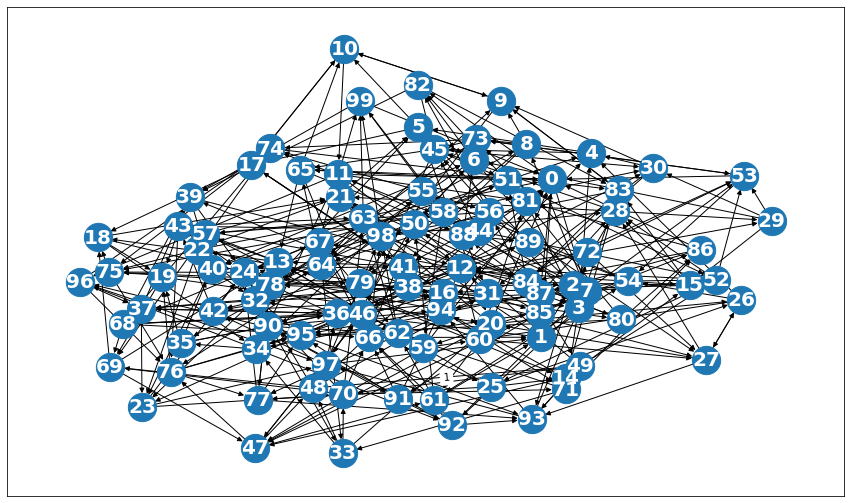

In [41]:
pos = nx.spring_layout(G)
plt.figure(3,figsize=(15,9)) 
nx.draw_networkx(G, pos, with_labels=True, font_weight='bold', font_color='white', font_size=20, node_size=800)
labels = nx.get_edge_attributes(G,'reward')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

### Value Iteration

In [42]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def value_iteration(env, max_iterations=100000, lmbda=0.9, verbose=1):
    stateValue = [0 for i in range(n_states)]
    newStateValue = stateValue.copy()
    iterations = 0
    start_time = time.time()

    for i in range(max_iterations):
        
        if verbose>0: print("Iteration: {}".format(i))
        
        for state in range(n_states):
            action_values = []      
            
            for action in range(n_actions):
                state_value = 0
                
                for s in range(len(env[state][action])):
                    # print(s)
                    prob, next_state, reward, done = env[state][action][s]
                    
                    if verbose>1: 
                        print("Iteration: {} State: {} Action: {} Prob: {} Next State: {} Reward: {}".format(i, state, action, prob, next_state, reward))
                    state_action_value = prob * (reward + lmbda*stateValue[next_state])
                    state_value += state_action_value
                
                action_values.append(state_value)
                best_action = np.argmax(np.asarray(action_values))
                newStateValue[state] = action_values[best_action]
        
        # if i > 1000: 
        if verbose>0: print("Delta V: {}".format(np.max(np.abs(np.array(stateValue) - np.array(newStateValue)))))
        if np.max(np.abs(np.array(stateValue) - np.array(newStateValue))) < 0.0001:
            break
            
        stateValue = newStateValue.copy()
        iterations += 1
    
    duration = time.time() - start_time

    return stateValue, iterations, duration 

In [43]:
# the following function was inspired by and adapted from: https://github.com/realdiganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(n_states)]
    for state in range(n_states):
        action_values = []
        for action in range(n_actions):
            action_value = 0
            # print(env.P[state][action])
            for i in range(len(env[state][action])):
                prob, next_state, r, _ = env[state][action][i]
                # print("I: {} R: {}".format(i, r))
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
        # print("State: {} Action Values: {} Best Action: {}".format(state, action_values, best_action))
    return policy 

In [44]:
n_states = 100
n_actions = 4
n_rewards = 1

# select which state actions gets a reward
# n_state_actions = n_actions * n_states
# selected_state_actions = np.arange(n_state_actions)
# random.shuffle(selected_state_actions)
# selected_state_actions=selected_state_actions[:n_rewards]

In [45]:
stateValues, iterations, duration = value_iteration(env1, max_iterations=100000, verbose=0)
policy_value_iteration = get_policy(env1, stateValues)
evaluation_data.append(('Randomized Small', 'Value Iteration', sum(stateValues), iterations, duration))

In [46]:
n_states = 10000
n_actions = 10
n_rewards = 2

# select which state actions gets a reward
# n_state_actions = n_actions * n_states
# selected_state_actions = np.arange(n_state_actions)
# random.shuffle(selected_state_actions)
# selected_state_actions=selected_state_actions[:n_rewards]

In [47]:
stateValues, iterations, duration = value_iteration(env2, max_iterations=100000, verbose=0)
policy_value_iteration = get_policy(env2, stateValues)
evaluation_data.append(('Randomized Large', 'Value Iteration', sum(stateValues), iterations, duration))

In [48]:
evaluation_data

[('Frozen Lake',
  'Value Iteration',
  3.5886959888016294,
  45,
  0.13098716735839844),
 ('Frozen Lake',
  'Policy Iteration',
  3.61596731425977,
  6,
  0.018025875091552734),
 ('Frozen Lake', 'Q-learning', 4.209304760430811, 58360, 62.61495876312256),
 ('Randomized Small',
  'Value Iteration',
  169.37541956890936,
  88,
  0.1907062530517578),
 ('Randomized Large',
  'Value Iteration',
  16205.200486031636,
  88,
  38.598506927490234)]

In [49]:
sum(stateValues)

16205.200486031636

### Policy Iteration

In [50]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_vpi(pi, env, gamma):
    # use pi[state] to access the action that's prescribed by this policy
    a = np.identity(n_states) 
    b = np.zeros(n_states)
    # print(a)
    # print(b) 
    
    for state in range(n_states):
        for probability, nextstate, reward, done in env[state][pi[state]]:
            a[state][nextstate] = a[state][nextstate] - gamma * probability
            # print(probability * reward)
            b[state] += probability * reward
    
    # print(a)
    # print(b)
    V = np.linalg.solve(a, b)
    return V

In [51]:
n_states = 100
n_actions = 4
n_rewards = 1

# select which state actions gets a reward
# n_state_actions = n_actions * n_states
# selected_state_actions = np.arange(n_state_actions)
# random.shuffle(selected_state_actions)
# selected_state_actions=selected_state_actions[:n_rewards]

In [52]:
pi = np.arange(n_states) % n_actions
Vpi = compute_vpi(pi, env1, 0.9)

In [53]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_qpi(vpi, env, gamma):
    Qpi = np.zeros([n_states, n_actions])
    for state in range(n_states):
        for action in range(n_actions):
            for probability, nextstate, reward, done in env[state][action]:
                Qpi[state][action] += probability * (reward + gamma * vpi[nextstate]) 
    return Qpi

In [54]:
Qpi = compute_qpi(Vpi, env1, 0.9)

In [55]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def policy_iteration(env, gamma, nIt):
    Vs = []
    pis = []
    pi_prev = np.zeros(n_states, dtype='int')
    pis.append(pi_prev)
    start_time = time.time()
    print("Iteration | # chg actions | V[0]")
    print("----------+---------------+---------")
    for it in range(nIt):        
        
        # you need to compute qpi which is the state-action values for current pi
        vpi = compute_vpi(pis[-1], env, gamma=gamma)
        qpi = compute_qpi(vpi, env, gamma=gamma)
        pi = qpi.argmax(axis=1)
        print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        pi_prev = pi

        if it > 1 and np.max(np.abs(np.array(Vs[-1]) - np.array(Vs[-2]))) < 0.0001:
            break

    duration = time.time() - start_time
    return Vs, pis, it, duration

In [56]:
Vs_PI, pis_PI, iterations, duration = policy_iteration(env1, gamma=0.9, nIt=20)
evaluation_data.append(('Randomized Small', 'Policy Iteration', sum(Vs_PI[-1]), iterations, duration))

Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |     74        | 0.00636
   1      |     58        | 1.78018
   2      |     28        | 1.78018
   3      |     16        | 1.78018
   4      |      1        | 1.78018
   5      |      0        | 1.78018


In [57]:
n_states = 10000
n_actions = 10
n_rewards = 2

# select which state actions gets a reward
# n_state_actions = n_actions * n_states
# selected_state_actions = np.arange(n_state_actions)
# random.shuffle(selected_state_actions)
# selected_state_actions=selected_state_actions[:n_rewards]

In [58]:
pi = np.arange(n_states) % n_actions
Vpi = compute_vpi(pi, env2, 0.9)

In [59]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def compute_qpi(vpi, env, gamma):
    Qpi = np.zeros([n_states, n_actions])
    for state in range(n_states):
        for action in range(n_actions):
            for probability, nextstate, reward, done in env[state][action]:
                Qpi[state][action] += probability * (reward + gamma * vpi[nextstate]) 
    return Qpi

In [60]:
Qpi = compute_qpi(Vpi, env2, 0.9)

In [61]:
# the following function was inspired by and adapted from: https://github.com/hollygrimm/markov-decision-processes/blob/master/lab1/Lab%201%20-%20Problem%202.ipynb
def policy_iteration(env, gamma, nIt):
    Vs = []
    pis = []
    pi_prev = np.zeros(n_states, dtype='int')
    pis.append(pi_prev)
    start_time = time.time()
    print("Iteration | # chg actions | V[0]")
    print("----------+---------------+---------")
    for it in range(nIt):        
        
        # you need to compute qpi which is the state-action values for current pi
        vpi = compute_vpi(pis[-1], env, gamma=gamma)
        qpi = compute_qpi(vpi, env, gamma=gamma)
        pi = qpi.argmax(axis=1)
        print("%4i      | %6i        | %6.5f"%(it, (pi != pi_prev).sum(), vpi[0]))
        Vs.append(vpi)
        pis.append(pi)
        pi_prev = pi

        if it > 1 and np.max(np.abs(np.array(Vs[-1]) - np.array(Vs[-2]))) < 0.0001:
            break

    duration = time.time() - start_time
    return Vs, pis, it, duration

In [62]:
Vs_PI, pis_PI, iterations, duration = policy_iteration(env2, gamma=0.9, nIt=20)
evaluation_data.append(('Randomized Large', 'Policy Iteration', sum(Vs_PI[-1]), iterations, duration))

Iteration | # chg actions | V[0]
----------+---------------+---------
   0      |      2        | 0.00000
   1      |   8971        | 0.00000
   2      |   8806        | 0.44528
   3      |   8044        | 0.64048
   4      |   6268        | 1.78018
   5      |   2537        | 1.78018
   6      |    406        | 1.78018
   7      |     25        | 1.78018
   8      |      0        | 1.78018


### Q-learning

In [63]:
n_states = 100
n_actions = 4
n_rewards = 1

# select which state actions gets a reward
# n_state_actions = n_actions * n_states
# selected_state_actions = np.arange(n_state_actions)
# random.shuffle(selected_state_actions)
# selected_state_actions=selected_state_actions[:n_rewards]

In [64]:
qtable = np.zeros((n_states, n_actions))
qtable.shape

(100, 4)

In [65]:
# total_episodes = 30000        # Total episodes
learning_rate = 0.9           # Learning rate
max_steps = 99999999                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.1            # Minimum exploration probability 
decay_rate = 0.01            # Exponential decay rate for exploration prob

In [66]:
# the following function was inspired by and adapted from: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb

# List of rewards
rewards = []
reward_achieved = 0
episode = 0
iterations = 0
duration = 0
diffs = []

start_time = time.time()

# 2 For life or until learning is stopped
while True:

    # Reset the environment
    state = 0
    old_state = 0
    step = 0
    done = False
    total_rewards = 0

    old_qtable = qtable.copy()
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
            # print("Exploiting knowledge!")

        # Else doing a random choice --> exploration
        else:
            action = random.choice(np.arange(n_actions))
            # print("Randomly exploring!")

        # print("Action: {}".format(action))

        # Take the action (a) and observe the outcome state(s') and reward (r)
        info, new_state, reward, done = env1[state][action][0]
        # print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))

        # if done and reward == 0:
        #     reward = -0.5

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        old_state = state
        state = new_state
        
        # print(total_rewards)
        # If done (if we're dead) : finish episode
        if total_rewards == 10:
            # print("Done") 
            reward_achieved += 1
            # print(old_state, action)
            # print(qtable[old_state, action])
            # print(learning_rate * (reward + gamma * np.max(qtable[state, :]) - qtable[old_state, action]))
            # # Reduce epsilon (because we need less and less exploration)
            # print(reward_achieved)
            # print(decay_rate)
            # print(np.exp(-decay_rate*reward_achieved))
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*reward_achieved)
            # print("Epsilon: {}".format(epsilon)) 
            print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))
            break
        
    rewards.append(total_rewards)
    episode += 1
    iterations += 1

    # print(diffs[-9:])
    diffs.append(np.max(np.abs(np.array(old_qtable) - np.array(qtable))))
    if sum(rewards)>50 and sum(diffs[-9:]) < 0.0001:
        break

    # if abs(epsilon - min_epsilon) < 0.0001:
    #     break

duration = time.time() - start_time

print ("Number of rewards: " +  str(sum(rewards)))
print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)
evaluation_data.append(('Randomized Small', 'Q-learning', np.sum(qtable) / n_actions, iterations, duration))

Episode: 0 Action: 0 New State: 49 R: 1 Epsilon: 0.9910448503742513
Episode: 1 Action: 0 New State: 49 R: 1 Epsilon: 0.9821788059760798
Episode: 2 Action: 0 New State: 49 R: 1 Epsilon: 0.9734009801936573
Episode: 3 Action: 0 New State: 49 R: 1 Epsilon: 0.9647104952370908
Episode: 4 Action: 0 New State: 49 R: 1 Epsilon: 0.9561064820506426
Episode: 5 Action: 0 New State: 49 R: 1 Epsilon: 0.9475880802258239
Episode: 6 Action: 0 New State: 49 R: 1 Epsilon: 0.9391544379153535
Episode: 7 Action: 0 New State: 49 R: 1 Epsilon: 0.9308047117479722
Episode: 8 Action: 0 New State: 49 R: 1 Epsilon: 0.9225380667441053
Episode: 9 Action: 0 New State: 49 R: 1 Epsilon: 0.9143536762323635
Episode: 10 Action: 0 New State: 49 R: 1 Epsilon: 0.9062507217668754
Episode: 11 Action: 0 New State: 49 R: 1 Epsilon: 0.8982283930454418
Episode: 12 Action: 0 New State: 49 R: 1 Epsilon: 0.8902858878285052
Episode: 13 Action: 0 New State: 49 R: 1 Epsilon: 0.8824224118589252
Episode: 14 Action: 0 New State: 49 R: 1 Eps

In [67]:
# policy = [np.argmax(i) for i in qtable]
policy = np.argmax(qtable, axis=1)

In [68]:
policy

array([2, 1, 3, 1, 1, 1, 1, 2, 3, 3, 0, 3, 0, 0, 2, 3, 2, 1, 0, 0, 2, 3,
       1, 1, 0, 2, 2, 2, 2, 3, 0, 0, 0, 1, 1, 3, 2, 1, 1, 2, 2, 1, 2, 0,
       3, 0, 0, 0, 0, 3, 3, 2, 1, 3, 2, 0, 1, 2, 0, 3, 3, 1, 0, 0, 1, 2,
       0, 0, 3, 3, 0, 3, 0, 3, 3, 2, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 2,
       3, 1, 0, 1, 3, 2, 3, 3, 0, 1, 2, 0])

In [69]:
n_states = 10000
n_actions = 10
n_rewards = 2

# select which state actions gets a reward
# n_state_actions = n_actions * n_states
# selected_state_actions = np.arange(n_state_actions)
# random.shuffle(selected_state_actions)
# selected_state_actions=selected_state_actions[:n_rewards]

In [70]:
qtable = np.zeros((n_states, n_actions))
qtable.shape

(10000, 10)

In [71]:
# total_episodes = 30000        # Total episodes
learning_rate = 0.9           # Learning rate
max_steps = 99999999                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.1            # Minimum exploration probability 
decay_rate = 0.01            # Exponential decay rate for exploration prob

In [72]:
# the following function was inspired by and adapted from: https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb

# List of rewards
rewards = []
reward_achieved = 0
episode = 0
iterations = 0
duration = 0
difs = []

start_time = time.time()

# 2 For life or until learning is stopped
while True:
    # Reset the environment
    state = 0
    old_state = 0
    step = 0
    done = False
    total_rewards = 0
    old_qtable = qtable.copy()

    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])
            # print("Exploiting knowledge!")

        # Else doing a random choice --> exploration
        else:
            action = random.choice(np.arange(n_actions))
            # print("Randomly exploring!")

        # print("Action: {}".format(action))

        # Take the action (a) and observe the outcome state(s') and reward (r)
        info, new_state, reward, done = env2[state][action][0]
        # print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))

        # if done and reward == 0:
        #     reward = -0.5

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        old_state = state
        state = new_state
        
        # print(total_rewards)
        # If done (if we're dead) : finish episode
        if total_rewards == 10:
            # print("Done") 
            reward_achieved += 1
            # print(old_state, action)
            # print(qtable[old_state, action])
            # print(learning_rate * (reward + gamma * np.max(qtable[state, :]) - qtable[old_state, action]))
            # # Reduce epsilon (because we need less and less exploration)
            # print(reward_achieved)
            # print(decay_rate)
            # print(np.exp(-decay_rate*reward_achieved))
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*reward_achieved)
            # print("Epsilon: {}".format(epsilon)) 
            print("Episode: {} Action: {} New State: {} R: {} Epsilon: {}".format(episode, action, new_state, reward, epsilon))
            break
        
    rewards.append(total_rewards)
    episode += 1
    iterations += 1

    diffs.append(np.max(np.abs(np.array(old_qtable) - np.array(qtable))))
    if sum(rewards)>50 and sum(diffs[-9:]) < 0.0001:
        break

    # if abs(epsilon - min_epsilon) < 0.0001:
    #     break

duration = time.time() - start_time

print ("Number of rewards: " +  str(sum(rewards)))
print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)
evaluation_data.append(('Randomized Large', 'Q-learning', np.sum(qtable) / n_actions, iterations, duration))

isode: 3455 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000088
Episode: 3456 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000088
Episode: 3457 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000087
Episode: 3458 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000087
Episode: 3459 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000085
Episode: 3460 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000084
Episode: 3461 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000084
Episode: 3462 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000082
Episode: 3463 Action: 5 New State: 6701 R: 1 Epsilon: 0.10000000000000082
Episode: 3464 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000081
Episode: 3465 Action: 5 New State: 6701 R: 1 Epsilon: 0.1000000000000008
Episode: 3466 Action: 3 New State: 5710 R: 1 Epsilon: 0.1000000000000008
Episode: 3467 Action: 3 New State: 5710 R: 1 Epsilon: 0.10000000000000078
Episode: 3468 Action: 3 New State: 5710 R:

In [73]:
evaluation_data

[('Frozen Lake',
  'Value Iteration',
  3.5886959888016294,
  45,
  0.13098716735839844),
 ('Frozen Lake',
  'Policy Iteration',
  3.61596731425977,
  6,
  0.018025875091552734),
 ('Frozen Lake', 'Q-learning', 4.209304760430811, 58360, 62.61495876312256),
 ('Randomized Small',
  'Value Iteration',
  169.37541956890936,
  88,
  0.1907062530517578),
 ('Randomized Large',
  'Value Iteration',
  16205.200486031636,
  88,
  38.598506927490234),
 ('Randomized Small',
  'Policy Iteration',
  169.3956460159705,
  5,
  0.010451078414916992),
 ('Randomized Large',
  'Policy Iteration',
  16207.269541649137,
  8,
  48.62921404838562),
 ('Randomized Small',
  'Q-learning',
  350.14564414674436,
  34,
  1.0898287296295166),
 ('Randomized Large',
  'Q-learning',
  31412.418893925496,
  3719,
  33.79541087150574)]

In [74]:
p = []
a = []
v = []
i = []
r = []
for f in evaluation_data:
    # print(f)
    p.append(f[0])
    a.append(f[1])
    v.append(round(f[2],2))
    i.append(f[3])
    r.append(round(f[4], 4))

In [75]:
layout = go.Layout(
    autosize=True,
    width=1000,
    height=400)
fig = go.Figure(
    data=[go.Table(header=dict(values=['Problem', 'Algorithm', 'Value', 'Iterations', 'Runtime']),
    cells=dict(values=[p, a, v, i, r]))], layout=layout)
fig.show()